###  Libraries

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from Initialization import Initialization
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Rings import Rings
from Common_Modules.Evaluation import Evaluator

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Global Variables

In [2]:
seed = 42
evaluator = Evaluator()
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = True
globalKernelKMeans_is_enabled = False
globalKernelKMeansPP_is_enabled = True

### Load Dataset

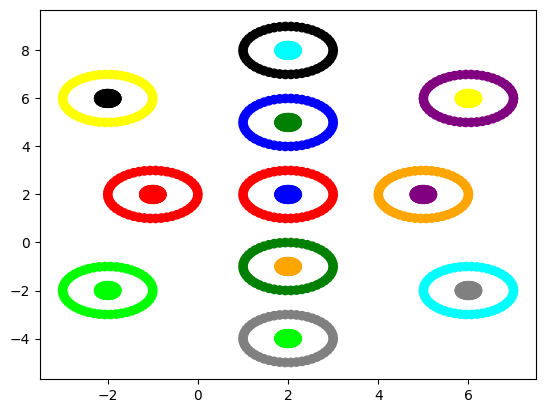

In [3]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

# Generate 5 pairs of data with specified center positions and unique IDs for each ring
centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2), (6, 6), (-2, 6), (2, 8), (6, -2), (2, -4), (-2, -2)]  # Specify center positions for each pair
#centers_coordinates = [(2, 2), (-2, 2)]
rings = Rings()

X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)
#X, y = rings.remove_samples_with_specific_label(X, y, 3)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors))

In [4]:
K = 22
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

### kMeans

In [5]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=ListedColormap(colors))

### Kernel kMeans

In [6]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_, cmap=ListedColormap(colors))
    plt.show()

### Kernel kMeans++

ACC: 0.67 PUR: 0.74 NMI: 0.88 ARI: 0.68


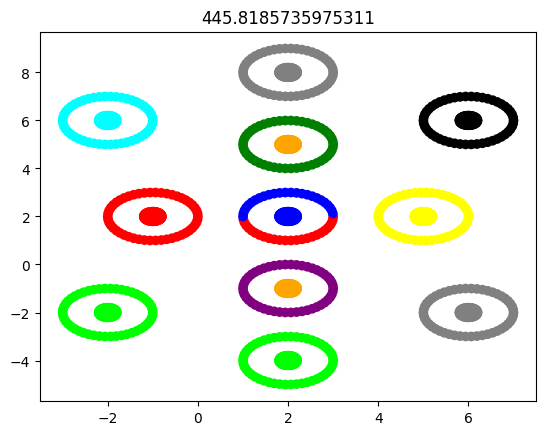

Ground Truth Error is: 421.793764703285


In [7]:
if(kernelKMeansPP_is_enabled):
    kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=10, init='k-means++', verbose=0)
    kernelKMeans.fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernelKMeans.labels_)
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=kernelKMeans.labels_, cmap=ListedColormap(colors))
    plt.title(kernelKMeans.inertia_)
    plt.show()

    # That's the function of grount truth error
    ground_truth_error = kernelKMeans.calculate_ground_truth_error(y)
    print(f"Ground Truth Error is: {ground_truth_error}")

### Global Kernel kMeans

In [8]:
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, verbose=1)
    globalKernelKMeans.fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeans.labels_[K])
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=globalKernelKMeans.labels_[K], cmap=ListedColormap(colors))
    plt.title(globalKernelKMeans.inertia_[K])
    plt.show()

### Global Kernel kMeans++

Solving 2-means
Solving 3-means
Solving 4-means
Solving 5-means
Solving 6-means
Solving 7-means
Solving 8-means
Solving 9-means
Solving 10-means
Solving 11-means
Solving 12-means
Solving 13-means
Solving 14-means
Solving 15-means
Solving 16-means
Solving 17-means
Solving 18-means
Solving 19-means
Solving 20-means
Solving 21-means
Solving 22-means
ACC: 0.91 PUR: 0.93 NMI: 0.97 ARI: 0.91


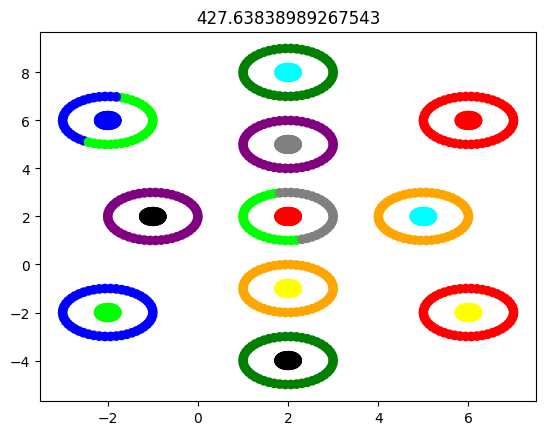

In [9]:
if(globalKernelKMeansPP_is_enabled):
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=50, sampling='batch', verbose=1)
    globalKernelKMeansPP.fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=globalKernelKMeansPP.labels_[K], cmap=ListedColormap(colors))
    plt.title(globalKernelKMeansPP.inertia_[K])
    plt.show()